# Arima
Данные взяты после сезонного дифференирования и дифференцирования со сдвигом на единицу.  
Будет использована модель типа Sarima(p,d,q)x(P,D,Q) для предсказания цены закрытия дня по еродоллору.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('data.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)
df.head()

,open,high,low,close,volume
date,,,,,
2011-04-15,0.0019,-0.0009,0.0020,-0.0070,-12600.0
2011-04-18,-0.0084,-0.0169,-0.0297,-0.0250,7772.0
2011-04-19,-0.0235,-0.0081,0.0103,0.0044,-2500.0
2011-04-20,0.0046,0.0169,-0.0008,0.0206,17753.0
2011-04-21,0.0203,0.0127,0.0218,0.0029,-9542.0


сезонное дифф-ие

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1080x504 with 0 Axes>

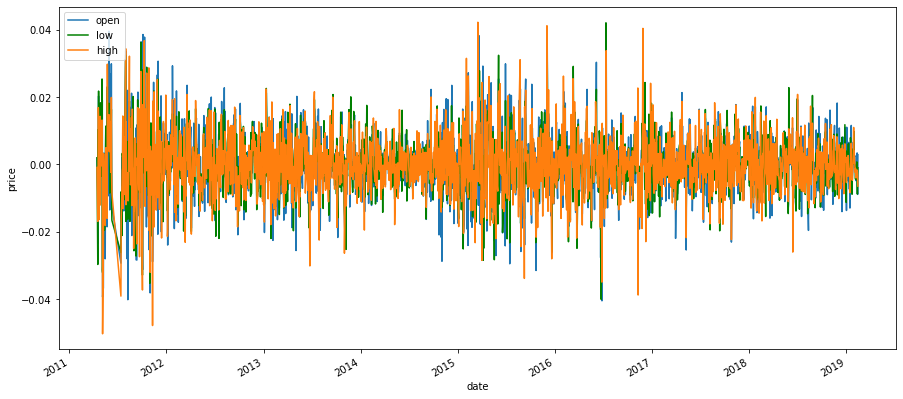

In [18]:
plt.figure(figsize(15,7))
plt.figure(figsize(15,7))
df.open.plot()
df.low.plot(color='g')
df.high.plot()
plt.ylabel('price')
plt.legend(loc='upper left')
pylab.show()

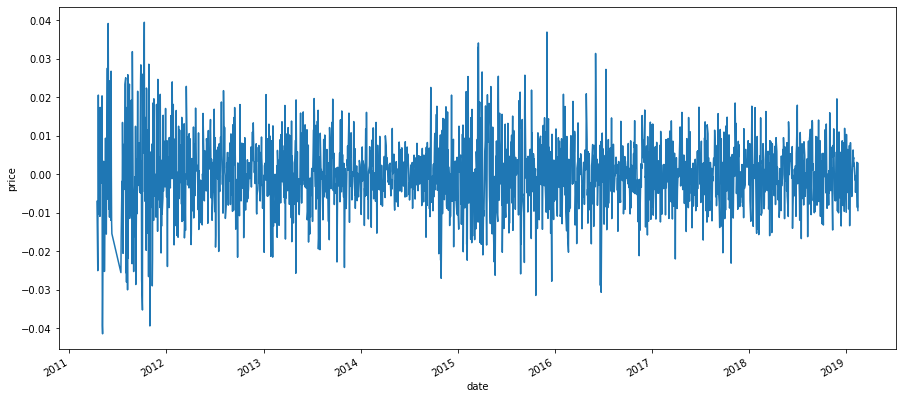

In [4]:
plt.figure(figsize(15,7))
df.close.plot() 
plt.ylabel('price')
pylab.show()

In [5]:
df.close, lmbda = stats.boxcox(np.abs(df['close']))

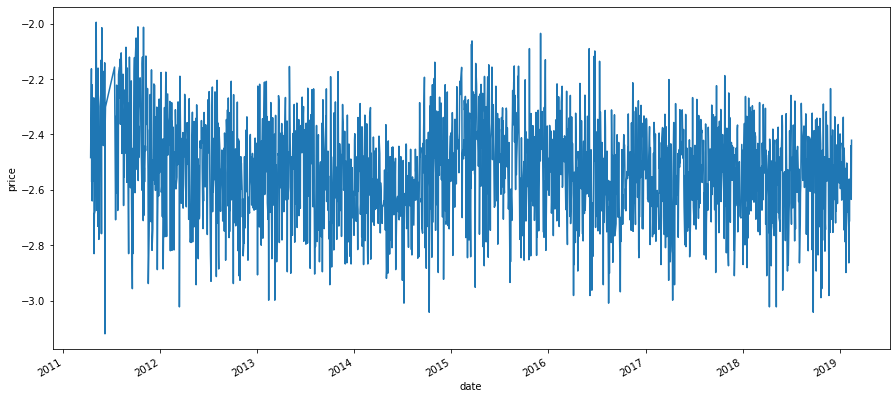

In [6]:
plt.figure(figsize(15,7))
df.close.plot() 
plt.ylabel('price')
pylab.show()

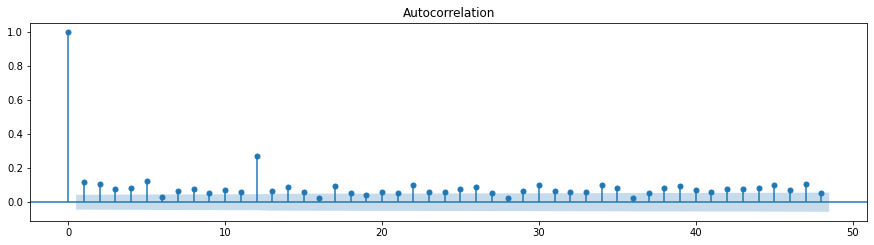

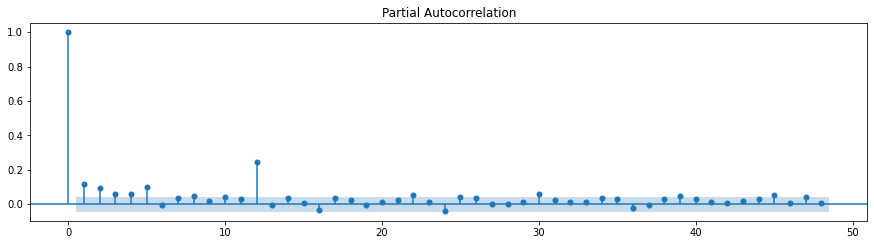

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['close'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['close'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

q = 1 так как на графики автокорреляции только один значимый несозонный лаг - лаг номер один
Q = 1 12 - значимый сезонных лагов на первом графике
p = 1 на графике частичной автокорреляции значим исключительно первый лаг 
P = 4 - на втором графике значим сезонный лаг 48, в то время как сезонный период равен 12

12.05.21

q = 5 так как на графики автокорреляции последний значимый несозонный лаг - лаг номер пять
Q = 1 - лаг 12 - значимый сезонных лагов на графике автокорреляции
p = 5 на графике частичной автокорреляции последним значимым (и несезонным) является 5 лаг
P = 1 - на втором графике значим сезонный лаг 12, в то время как сезонный период равен 12

In [8]:
qs = range(0,6)
Qs = range(0,1)
ps = range(0,6)
Ps = range(0,1)

d = 1
D = 1

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

180

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.close, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 2h 33min 38s


In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
139  (4, 3, 4, 0) -1093.828426
169  (5, 3, 4, 0) -1093.565278
79   (2, 3, 4, 0) -1085.959757
119  (3, 5, 4, 0) -1085.286133
149  (4, 5, 4, 0) -1079.506965


D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Анализ остатков

In [12]:
print(best_model.summary())

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                                      SARIMAX Results                                      
Dep. Variable:                               close   No. Observations:                 2035
Model:             SARIMAX(4, 1, 3)x(4, 1, [], 12)   Log Likelihood                 558.914
Date:                             Wed, 12 May 2021   AIC                          -1093.828
Time:                                     15:21:05   BIC                          -1026.486
Sample:                                          0   HQIC                         -1069.116
                                            - 2035                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9233      0.024    -39.133      0.000      -0.970      -0.877
ar.L2         -0.8646      

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.960959
Критерий Дики-Фуллера: p=0.000000


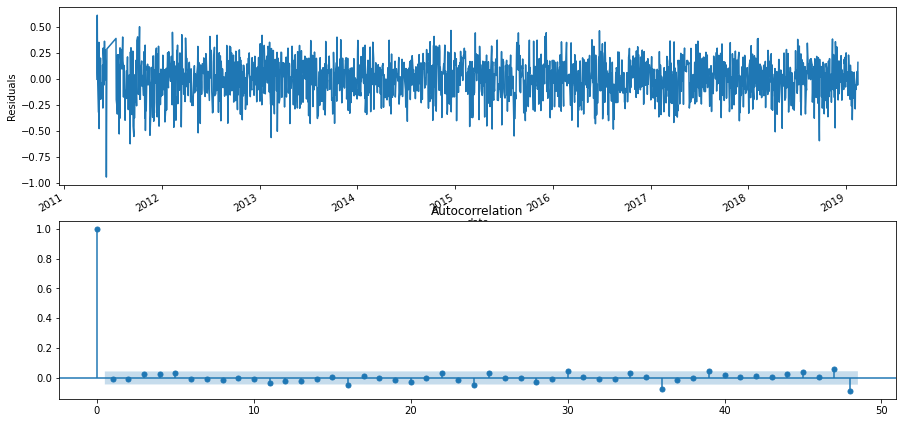

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

выводы

In [14]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
np.abs(df['close'])

date
2011-04-15    2.483513
2011-04-18    2.163208
2011-04-19    2.571414
2011-04-20    2.220728
2011-04-21    2.639930
                ...   
2019-02-11    2.627058
2019-02-12    2.531143
2019-02-13    2.440407
2019-02-14    2.634177
2019-02-15    2.420992
Name: close, Length: 2035, dtype: float64

In [16]:
#df.close, lmbda = stats.boxcox(np.abs(df['close']))

D:\apps\anaconda\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


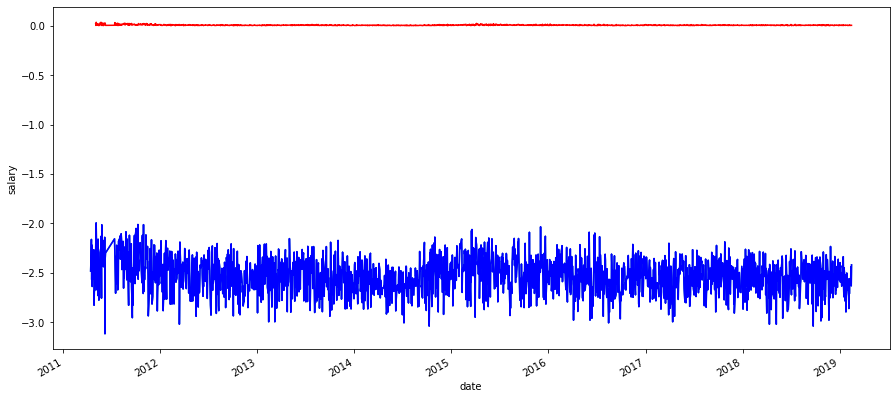

In [17]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df['close'].plot()#df.WAG_C_M.plot()
df.close.plot(color='b')
df.model[13:].plot(color='r')
plt.ylabel('salary')
pylab.show()

In [19]:
df

D:\apps\anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,open,high,low,close,volume,model
date,,,,,,
2011-04-15,0.00190,-0.00090,0.00200,-2.483513,-12600.0,1.000000
2011-04-18,-0.00840,-0.01690,-0.02970,-2.163208,7772.0,0.007000
2011-04-19,-0.02350,-0.00810,0.01030,-2.571414,-2500.0,0.025000
2011-04-20,0.00460,0.01690,-0.00080,-2.220728,17753.0,0.004400
2011-04-21,0.02030,0.01270,0.02180,-2.639930,-9542.0,0.020600
...,...,...,...,...,...,...
2019-02-11,-0.00410,-0.00178,0.00077,-2.627058,-25901.0,0.002433
2019-02-12,0.00343,-0.00165,-0.00204,-2.531143,6986.0,0.003673
2019-02-13,-0.00500,-0.00244,-0.00878,-2.440407,26586.0,0.005961
